In [54]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import DataFrame
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce



#显示所有列
pd.set_option('display.max_columns', None)

#显示所有行
pd.set_option('display.max_rows', None)



In [55]:
def read_health_dataframe() -> dict[str, DataFrame]:
  return {path.stem[0:2]:pd.read_csv(path, encoding="latin-1") for path in Path("./healthdata/").glob("*.csv")}

def read_chns_dataframe() -> dict[str, DataFrame]:
  return {path.stem:pd.read_sas(path) for path in Path("./chns/").glob("Master_*/*.sas7bdat") if not "Agriculture" in str(path) }

def read_video_data():
  pass

health_datas = read_health_dataframe()
#chns_datas = read_chns_dataframe()



In [56]:
# print(f"Total file: {len(chns_datas)}")
# idind_count = 0
# hhid_count = 0

# for (name, chns_data) in chns_datas.items():
#   columns_l = [column.lower() for column in chns_data.columns]
#   #print(f"---{name}---")
#   if "idind" in columns_l:
#     idind_count += 1
#   else:
#     pass
#    #print(f"{name} don't contain idind")
#   if "hhid" in columns_l:
#     hhid_count += 1
#   else:
#     print(f"{name} don't contain hhid")

# print(f"idint: {idind_count}, hhid: {hhid_count}")

In [57]:
#qu = reduce(lambda left, right: pd.merge(left, right, how='inner', on=['SEQN']), health_datas.values())
qu = health_datas["qu"].merge(health_datas["de"], how='inner', on=['SEQN']).merge(health_datas["me"], how='inner', on=['SEQN'])

In [58]:
qu_dpq = qu.loc[:,['SEQN','DPQ010',	'DPQ020',	'DPQ030',	'DPQ040',	'DPQ050',	'DPQ060',	'DPQ070',	'DPQ080',	'DPQ090']]

In [59]:
qu_dpq.dropna(thresh=9, inplace=True) # no more 9 NaN

In [60]:
a = qu_dpq.loc[:, ['DPQ010', 'DPQ020',	'DPQ030',	'DPQ040',	'DPQ050',	'DPQ060',	'DPQ070',	'DPQ080',	'DPQ090']]
a[a>3]=0 # 将大于 3 的DPQ值转为 0
sum = a.sum(axis=1)
#sum[sum <= 3] = 0
#sum[sum > 3] = 1

In [61]:
qu_dpq.insert(1, 'SUM', sum)
qu_dpq.head()
#qu_dpq

,SEQN,SUM,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090
0,73557,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,73557,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,73558,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,73558,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,73558,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
#qu_dpq.drop('SUM', axis=1, inplace=True)

In [63]:
qu.insert(1, 'SUM', sum)

In [64]:
qu = qu[qu['SUM'] >= 0]
print(qu.head(100))

      SEQN   SUM  ACD011A  ACD011B  ACD011C  ACD040  ACD110  ALQ101  ALQ110  \
0    73557   1.0      1.0      NaN      NaN     NaN     NaN     1.0     NaN   
1    73557   1.0      1.0      NaN      NaN     NaN     NaN     1.0     NaN   
2    73558   2.0      1.0      NaN      NaN     NaN     NaN     1.0     NaN   
3    73558   2.0      1.0      NaN      NaN     NaN     NaN     1.0     NaN   
4    73558   2.0      1.0      NaN      NaN     NaN     NaN     1.0     NaN   
5    73558   2.0      1.0      NaN      NaN     NaN     NaN     1.0     NaN   
6    73559   0.0      1.0      NaN      NaN     NaN     NaN     1.0     NaN   
7    73559   0.0      1.0      NaN      NaN     NaN     NaN     1.0     NaN   
8    73559   0.0      1.0      NaN      NaN     NaN     NaN     1.0     NaN   
9    73559   0.0      1.0      NaN      NaN     NaN     NaN     1.0     NaN   
10   73559   0.0      1.0      NaN      NaN     NaN     NaN     1.0     NaN   
12   73561   9.0      1.0      NaN      NaN     NaN 

In [65]:
qu.drop(['SEQN','DPQ010', 'DPQ020',	'DPQ030',	'DPQ040',	'DPQ050',	'DPQ060',	'DPQ070',	'DPQ080',	'DPQ090', "DPQ100"], axis=1, inplace=True)

In [66]:
#qu.fillna(0, inplace=True)
#qu = pd.get_dummies(qu)
qu = qu.select_dtypes(exclude=['object'])
qu.fillna(0, inplace=True)

In [67]:
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neural_network import MLPClassifier as DNN
from sklearn import svm

from sklearn.pipeline import Pipeline
from sklearn.utils.extmath import density

from sklearn import metrics

# split the data into features and target
X = qu.iloc[:, 1:]
y = qu.iloc[:, 0]

# split the data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=True) # 70% training and 30% test


In [68]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.25251076040172166

In [69]:
clf = DTC().fit(X_train, y_train)
clf.score(X_test, y_test)

0.8177905308464849

In [70]:
rfc = RandomForestClassifier().fit(X_train, y_train)
rfc.score(X_test, y_test)

0.8751793400286944

In [18]:
# dnn = DNN().fit(X_train, y_train)
# dnn.score(X_test, y_test)

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.18826249900326927

In [ ]:
#svm = svm.SVC().fit(X_train, y_train)
#svm.score(X_test, y_test)

0.25209280076536716

In [77]:
feature_names = X_train.columns
feature_importances = clf.feature_importances_
indices = np.argsort(feature_importances)[::-1][:500]
rankTop = []

for index in indices:
  rankTop.append(feature_names[index])
  print("feature %s (%f)" %(feature_names[index], feature_importances[index]))

feature RXDCOUNT (0.036218)
feature PFQ063B (0.022090)
feature SLQ050 (0.014391)
feature OCD395 (0.013044)
feature HSD010 (0.010368)
feature SLD010H (0.010297)
feature WTINT2YR (0.010229)
feature WHQ150 (0.009277)
feature WHD010 (0.008908)
feature SDMVSTRA (0.008878)
feature PAQ710 (0.008170)
feature INDFMMPI (0.008168)
feature CDQ010 (0.008086)
feature DMDHRAGE (0.008076)
feature INDFMPIR (0.007690)
feature CBD070 (0.007552)
feature MCQ180A (0.007230)
feature CBD110 (0.007128)
feature PFQ061T (0.007120)
feature SMD030 (0.006996)
feature WHD140 (0.006967)
feature WTMEC2YR (0.006807)
feature SXD031 (0.006800)
feature IND235 (0.006769)
feature CBD120 (0.006538)
feature ALQ130 (0.006527)
feature BPD058 (0.006455)
feature ALQ120Q (0.006285)
feature WHD050 (0.006250)
feature WHD120 (0.005758)
feature DMDEDUC2 (0.005638)
feature WHD110 (0.005409)
feature DLQ050 (0.005286)
feature MCQ300C (0.005072)
feature HUQ051 (0.004995)
feature RHD190 (0.004976)
feature CBQ580 (0.004954)
feature RIDAGEYR

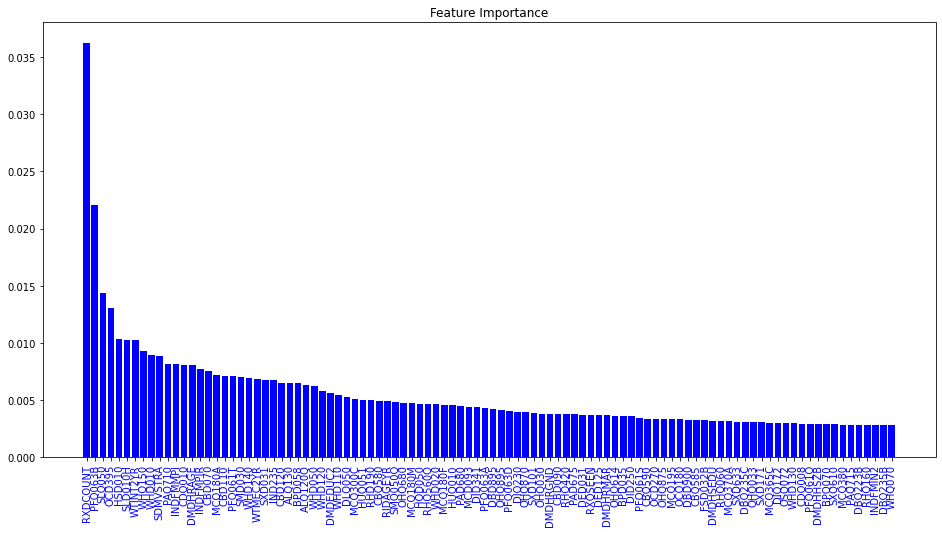

In [72]:
plt.figure(figsize=(16,8))
plt.title("Feature Importance")
plt.bar(range(len(indices)), feature_importances[indices], color='b')
plt.xticks(range(len(indices)), np.array(feature_names) [indices], color='b', rotation=90)
plt.show()

In [73]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(clf, random_state=1).fit(X_test, y_test) 

In [ ]:
eli5.show_weights(perm, feature_names=X_test.columns.tolist(),top=5000)

In [81]:
extractedX = X[rankTop]
X_train, X_test, y_train, y_test = train_test_split(extractedX, y, test_size=0.05, shuffle=True) # 70% training and 30% test

In [82]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.2682926829268293

In [87]:
X["DED120"].head(1000)

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
5         0.0
6         0.0
7         0.0
8         0.0
9         0.0
10        0.0
12        0.0
13        0.0
14        0.0
15        0.0
16       14.0
17       14.0
18       14.0
19       14.0
20       14.0
21       14.0
22       14.0
24        0.0
25        0.0
26        0.0
28       30.0
29       30.0
30       30.0
31        0.0
32        0.0
35        0.0
36        0.0
37        0.0
40        0.0
45      120.0
46        0.0
48       30.0
49        0.0
53       30.0
57       60.0
60      180.0
63        0.0
64       60.0
65        0.0
66        0.0
67        0.0
68        0.0
70      360.0
73       30.0
74        0.0
75        0.0
76        0.0
77        0.0
78        0.0
79        0.0
82        0.0
83        0.0
84        0.0
85        0.0
86        0.0
89        0.0
92        0.0
93        0.0
94        0.0
95        0.0
96        0.0
97        0.0
98        0.0
99       30.0
100      30.0
101      30.0
102   